Epoch  1 | Train Loss: 0.3452 Acc: 71.58% | Val Loss: 0.2171 SegF1: 0.636
Epoch  2 | Train Loss: 0.2034 Acc: 81.13% | Val Loss: 0.1672 SegF1: 0.722
Epoch  3 | Train Loss: 0.1659 Acc: 84.66% | Val Loss: 0.1380 SegF1: 0.784
Epoch  4 | Train Loss: 0.1392 Acc: 87.69% | Val Loss: 0.1282 SegF1: 0.790
Epoch  5 | Train Loss: 0.1259 Acc: 89.24% | Val Loss: 0.1262 SegF1: 0.821
Epoch  6 | Train Loss: 0.1198 Acc: 91.06% | Val Loss: 0.1138 SegF1: 0.839
Epoch  7 | Train Loss: 0.1083 Acc: 91.58% | Val Loss: 0.1037 SegF1: 0.842
Epoch  8 | Train Loss: 0.0987 Acc: 92.92% | Val Loss: 0.1024 SegF1: 0.864
Epoch  9 | Train Loss: 0.0890 Acc: 93.62% | Val Loss: 0.0957 SegF1: 0.843
Epoch 10 | Train Loss: 0.0866 Acc: 93.78% | Val Loss: 0.0932 SegF1: 0.837
Epoch 11 | Train Loss: 0.0777 Acc: 93.94% | Val Loss: 0.0978 SegF1: 0.898
Epoch 12 | Train Loss: 0.0796 Acc: 94.19% | Val Loss: 0.0947 SegF1: 0.821
Epoch 13 | Train Loss: 0.0774 Acc: 94.32% | Val Loss: 0.0917 SegF1: 0.867
Epoch 14 | Train Loss: 0.0733 Acc: 94.

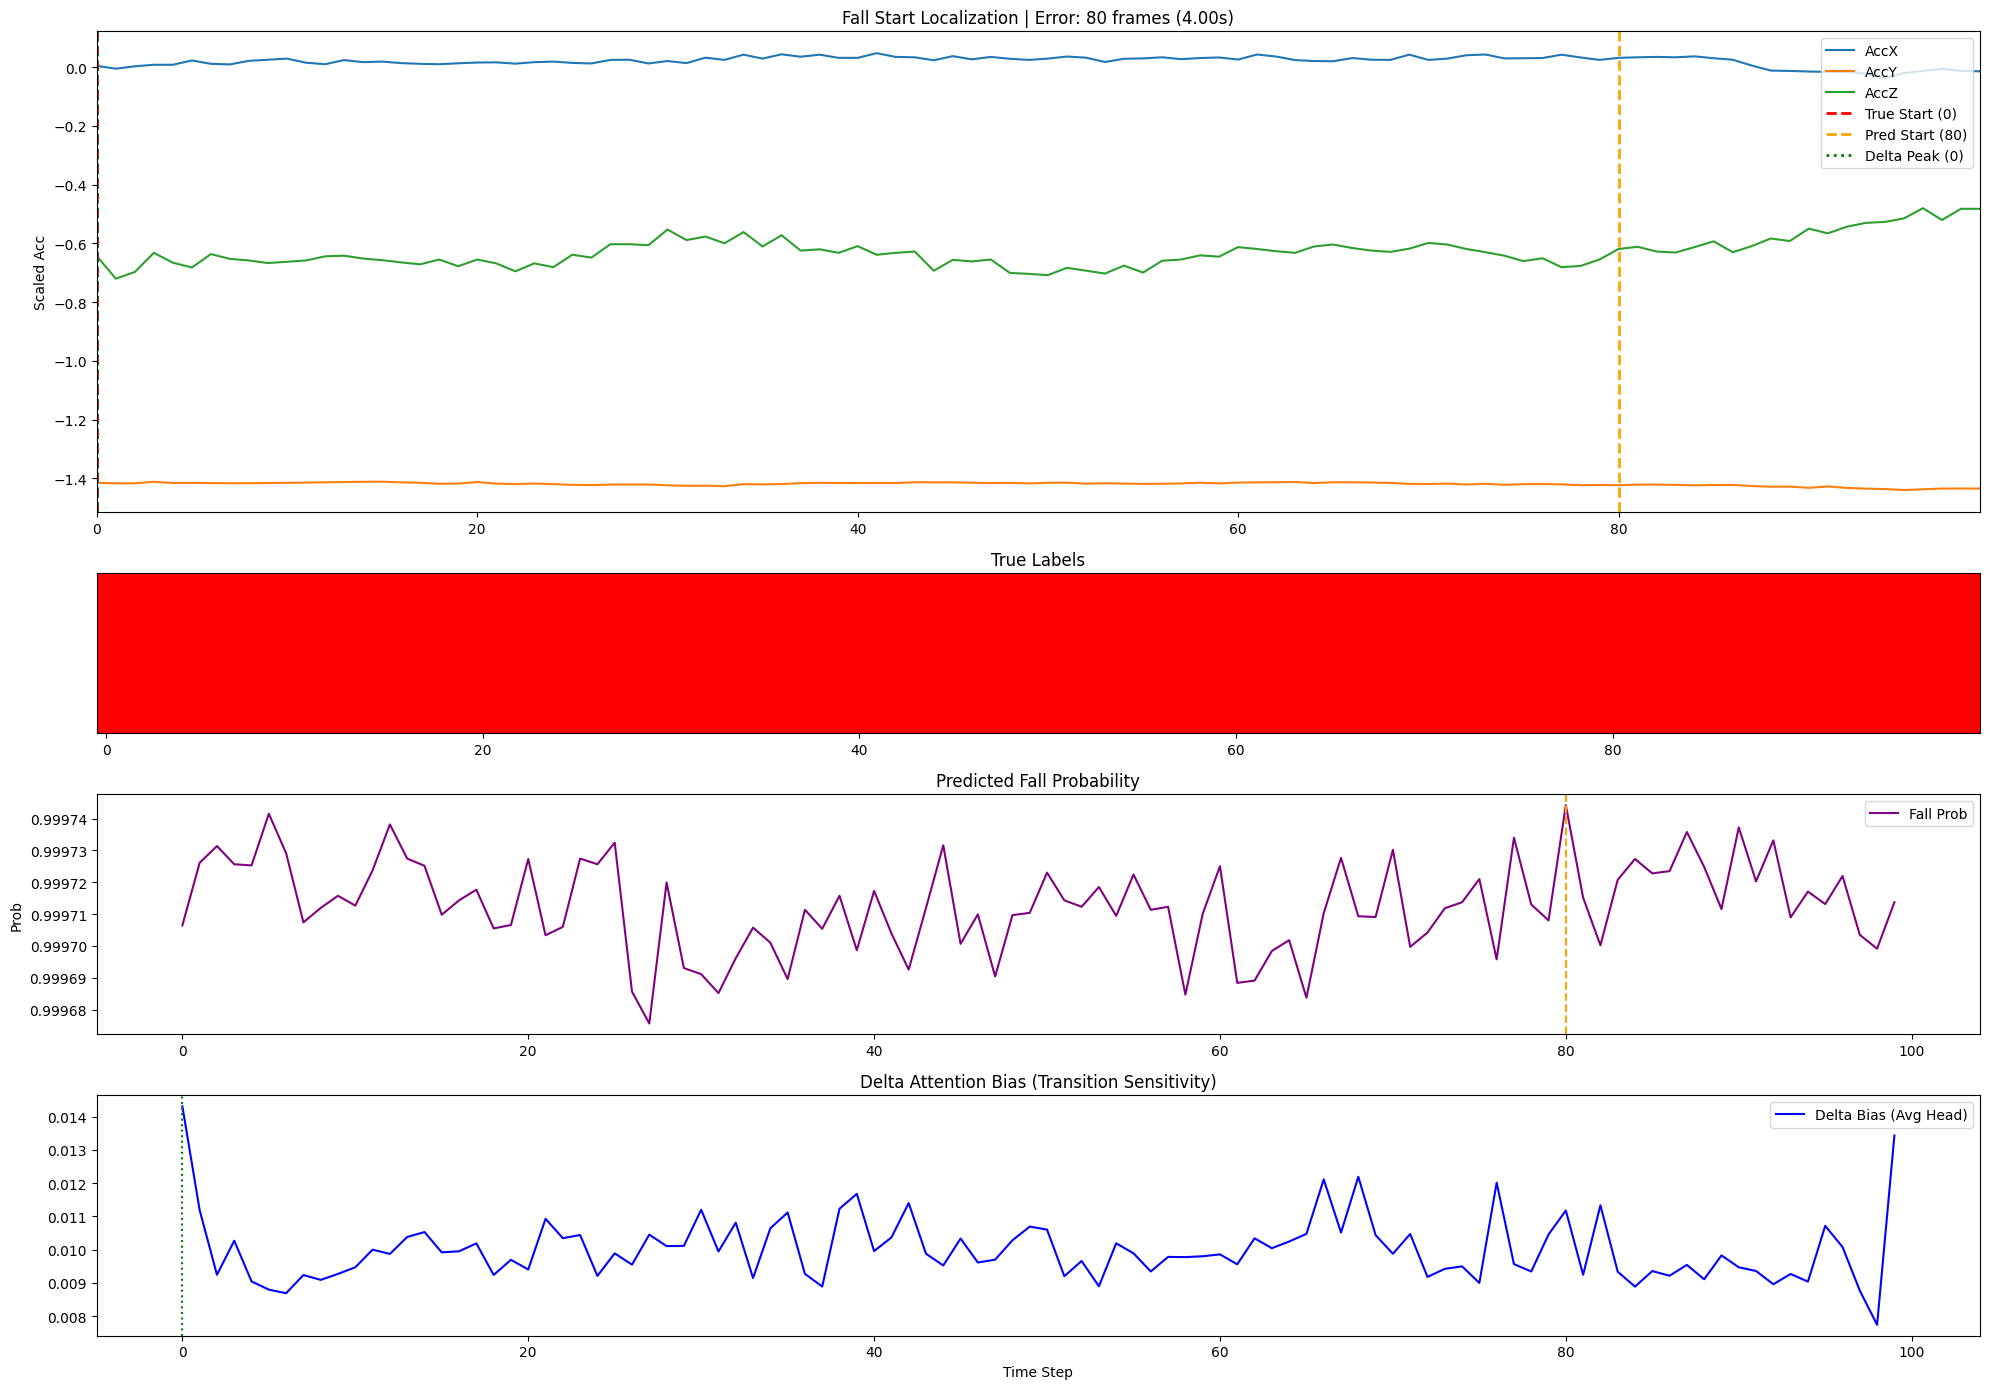

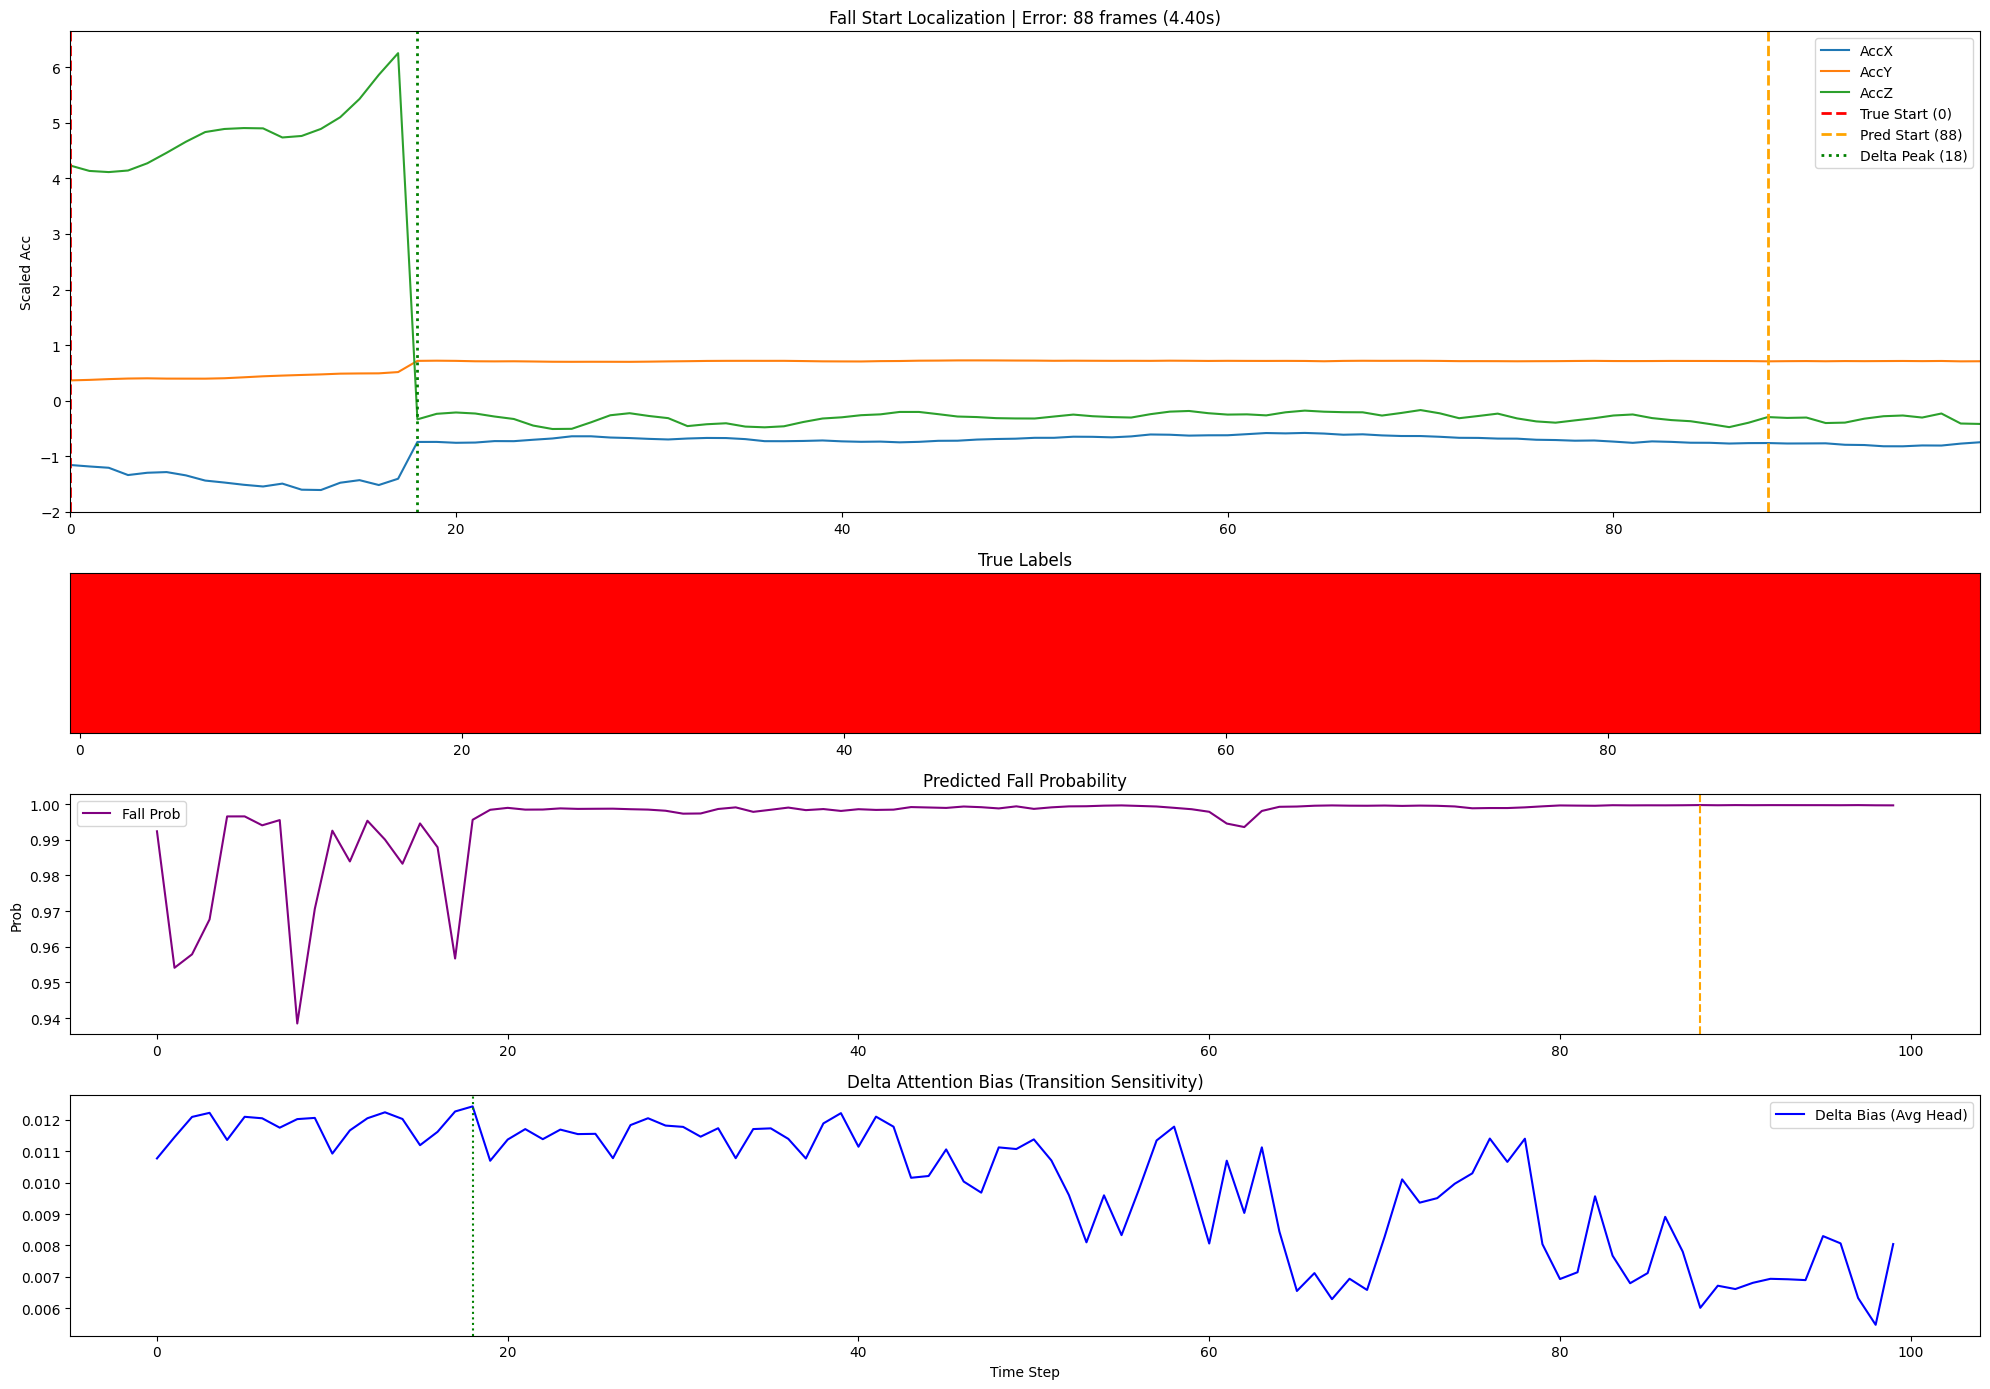

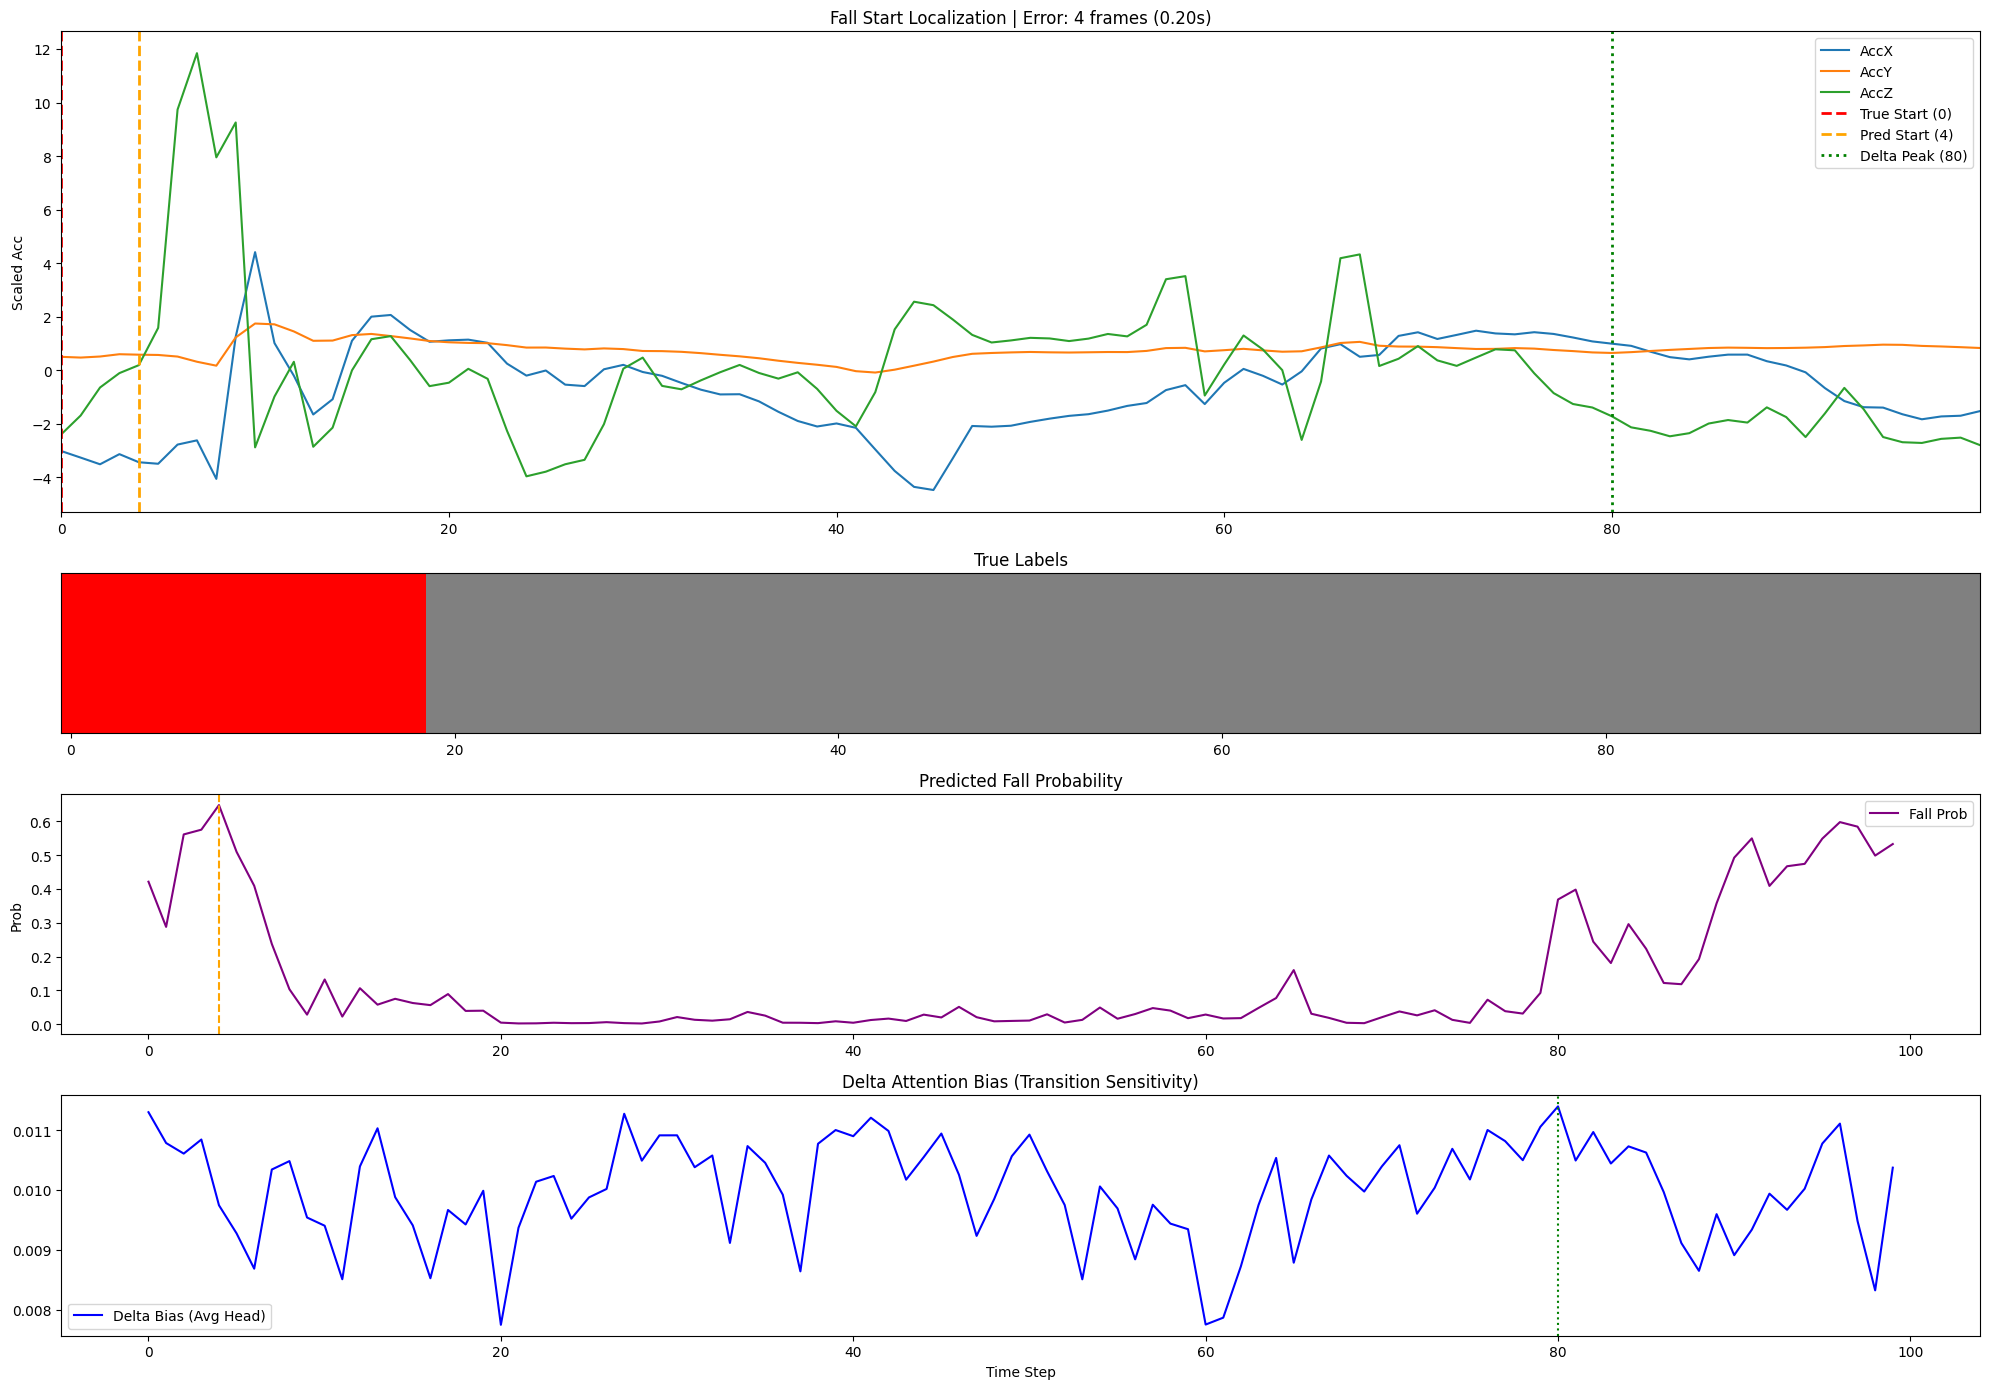

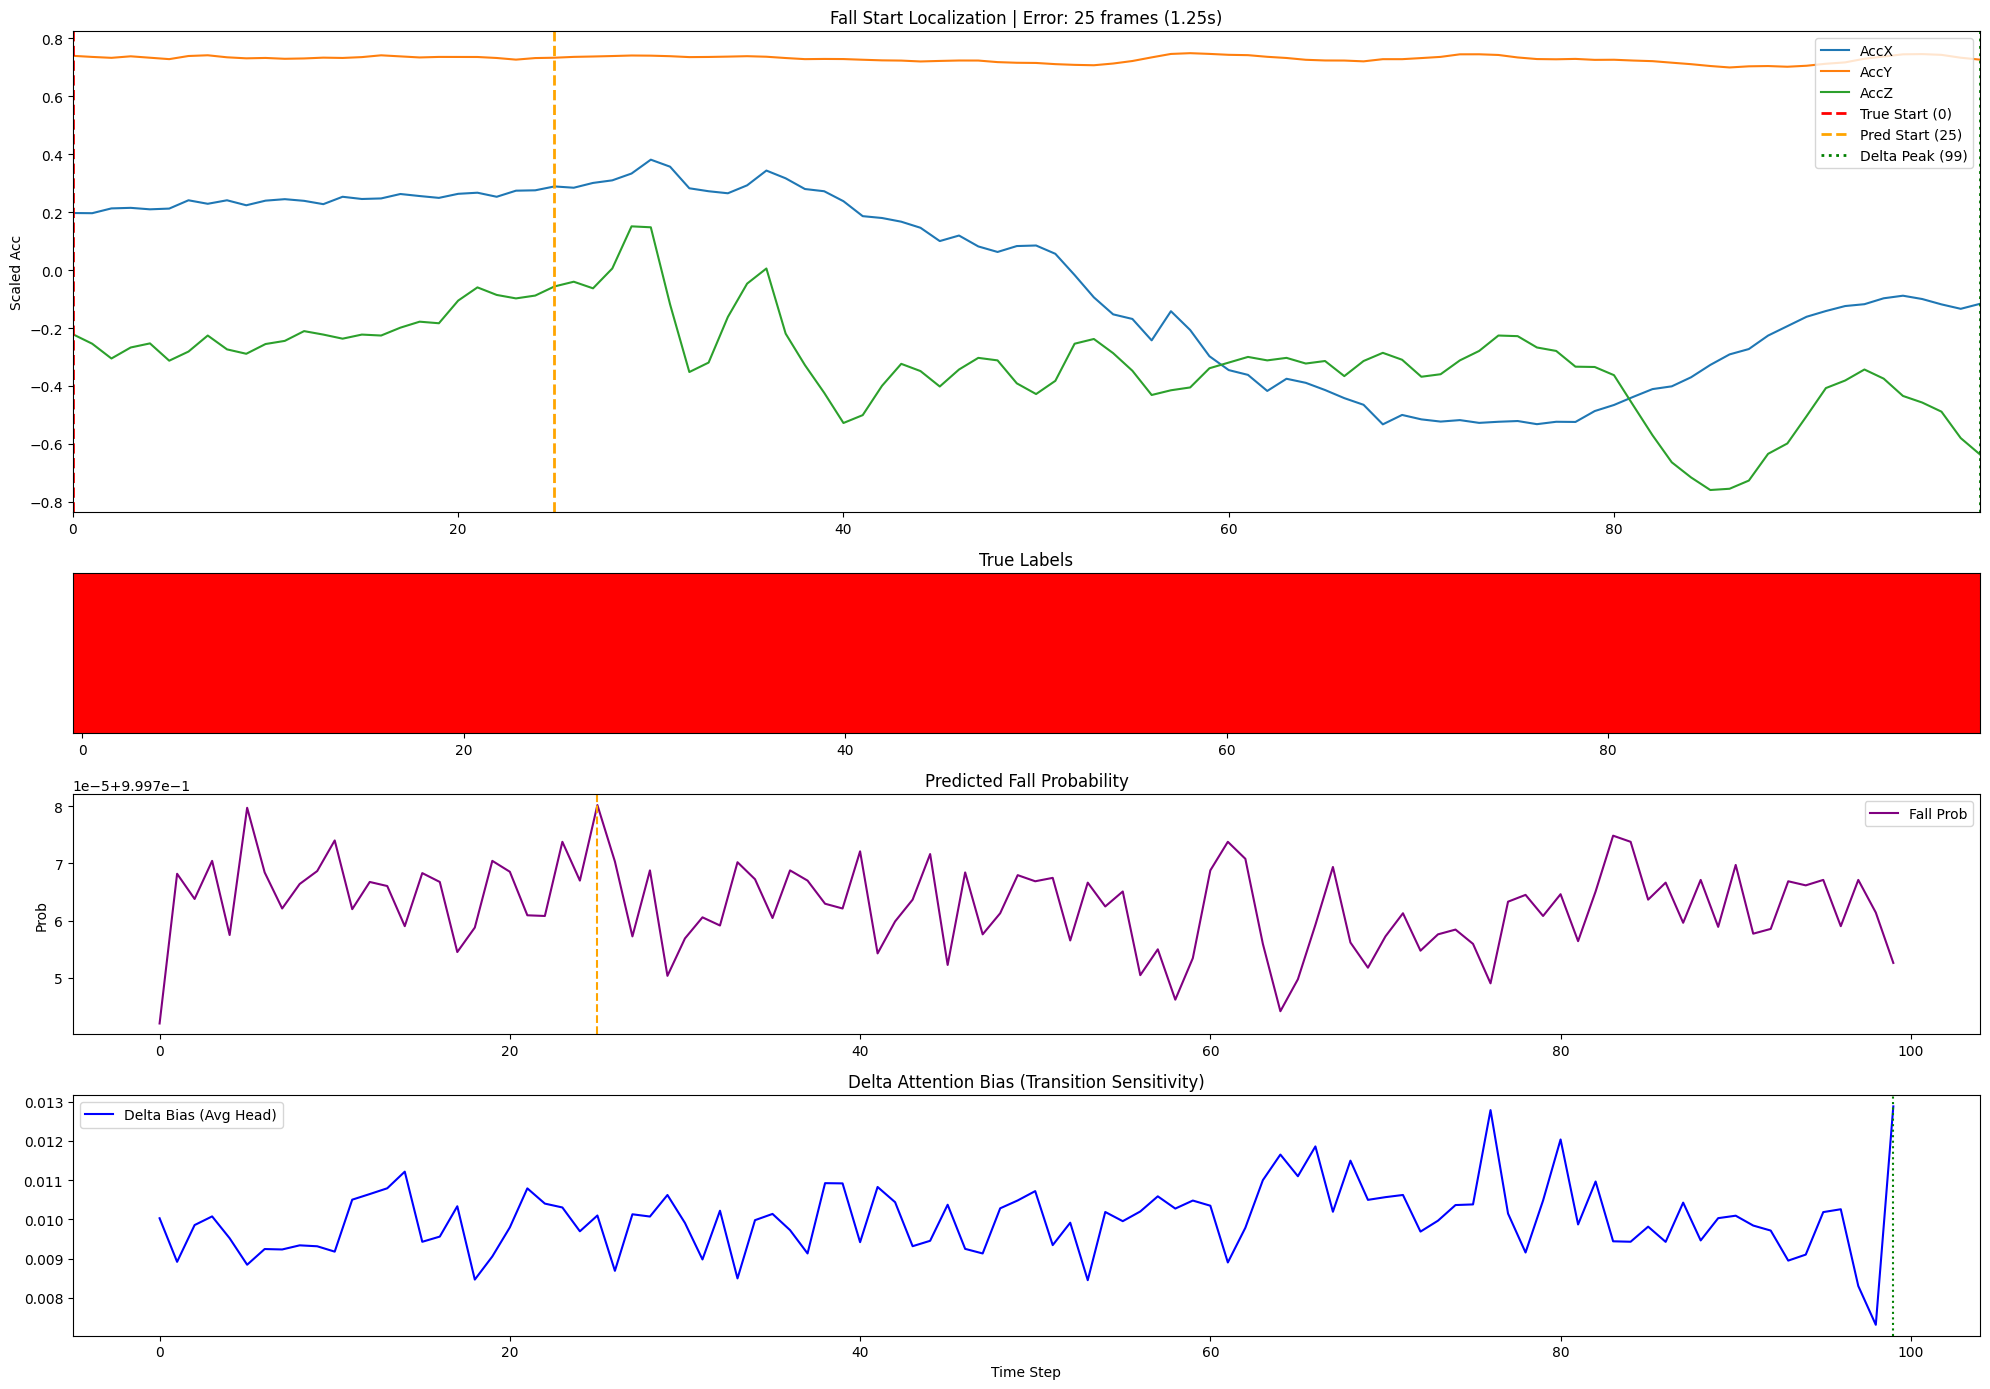

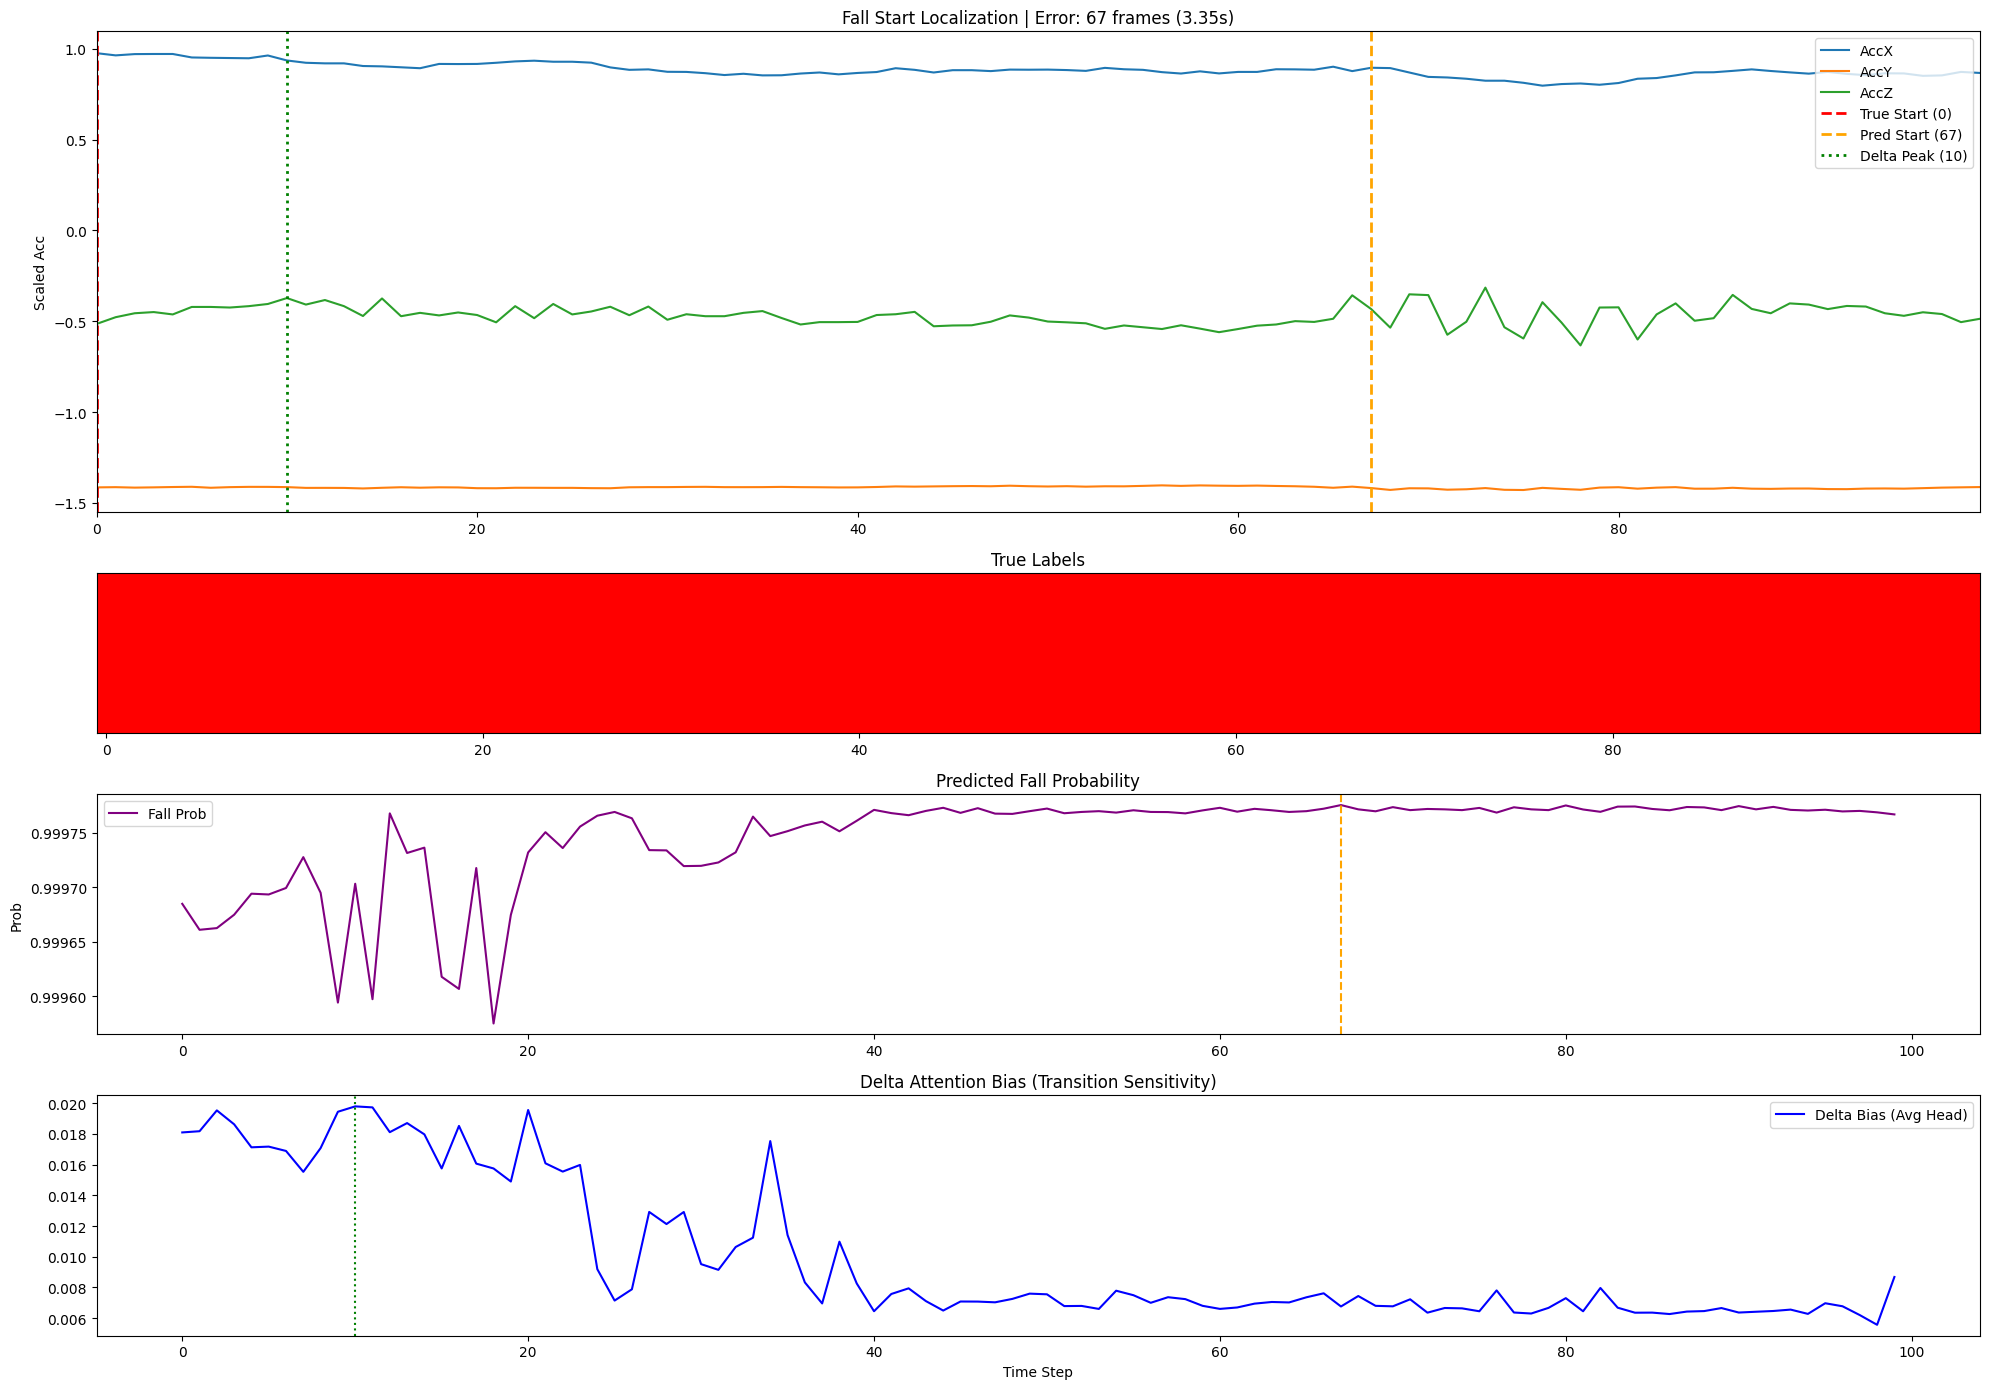

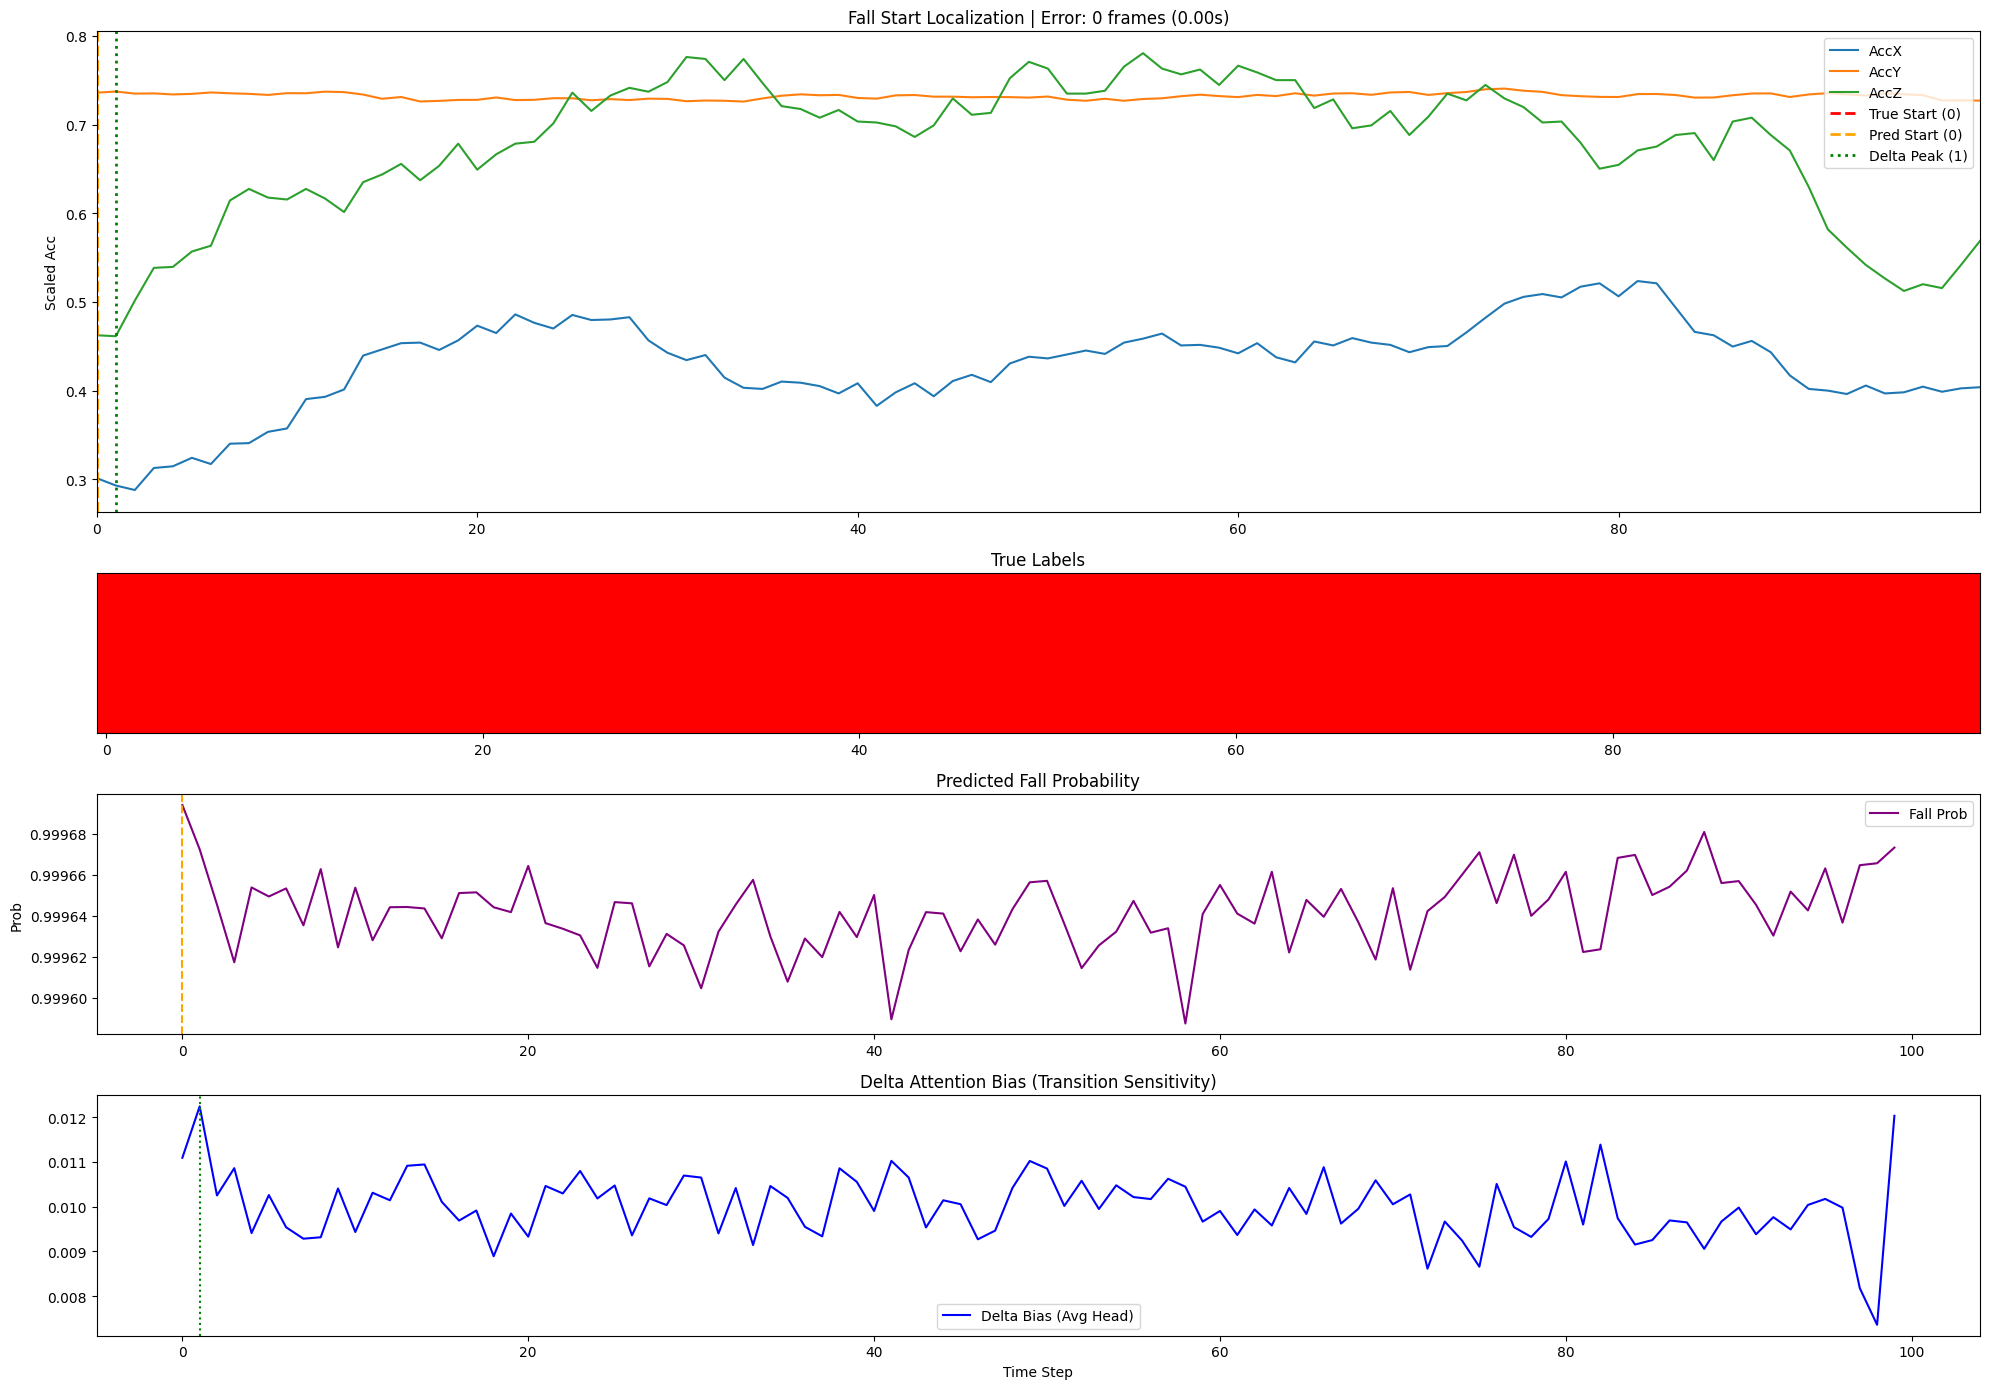

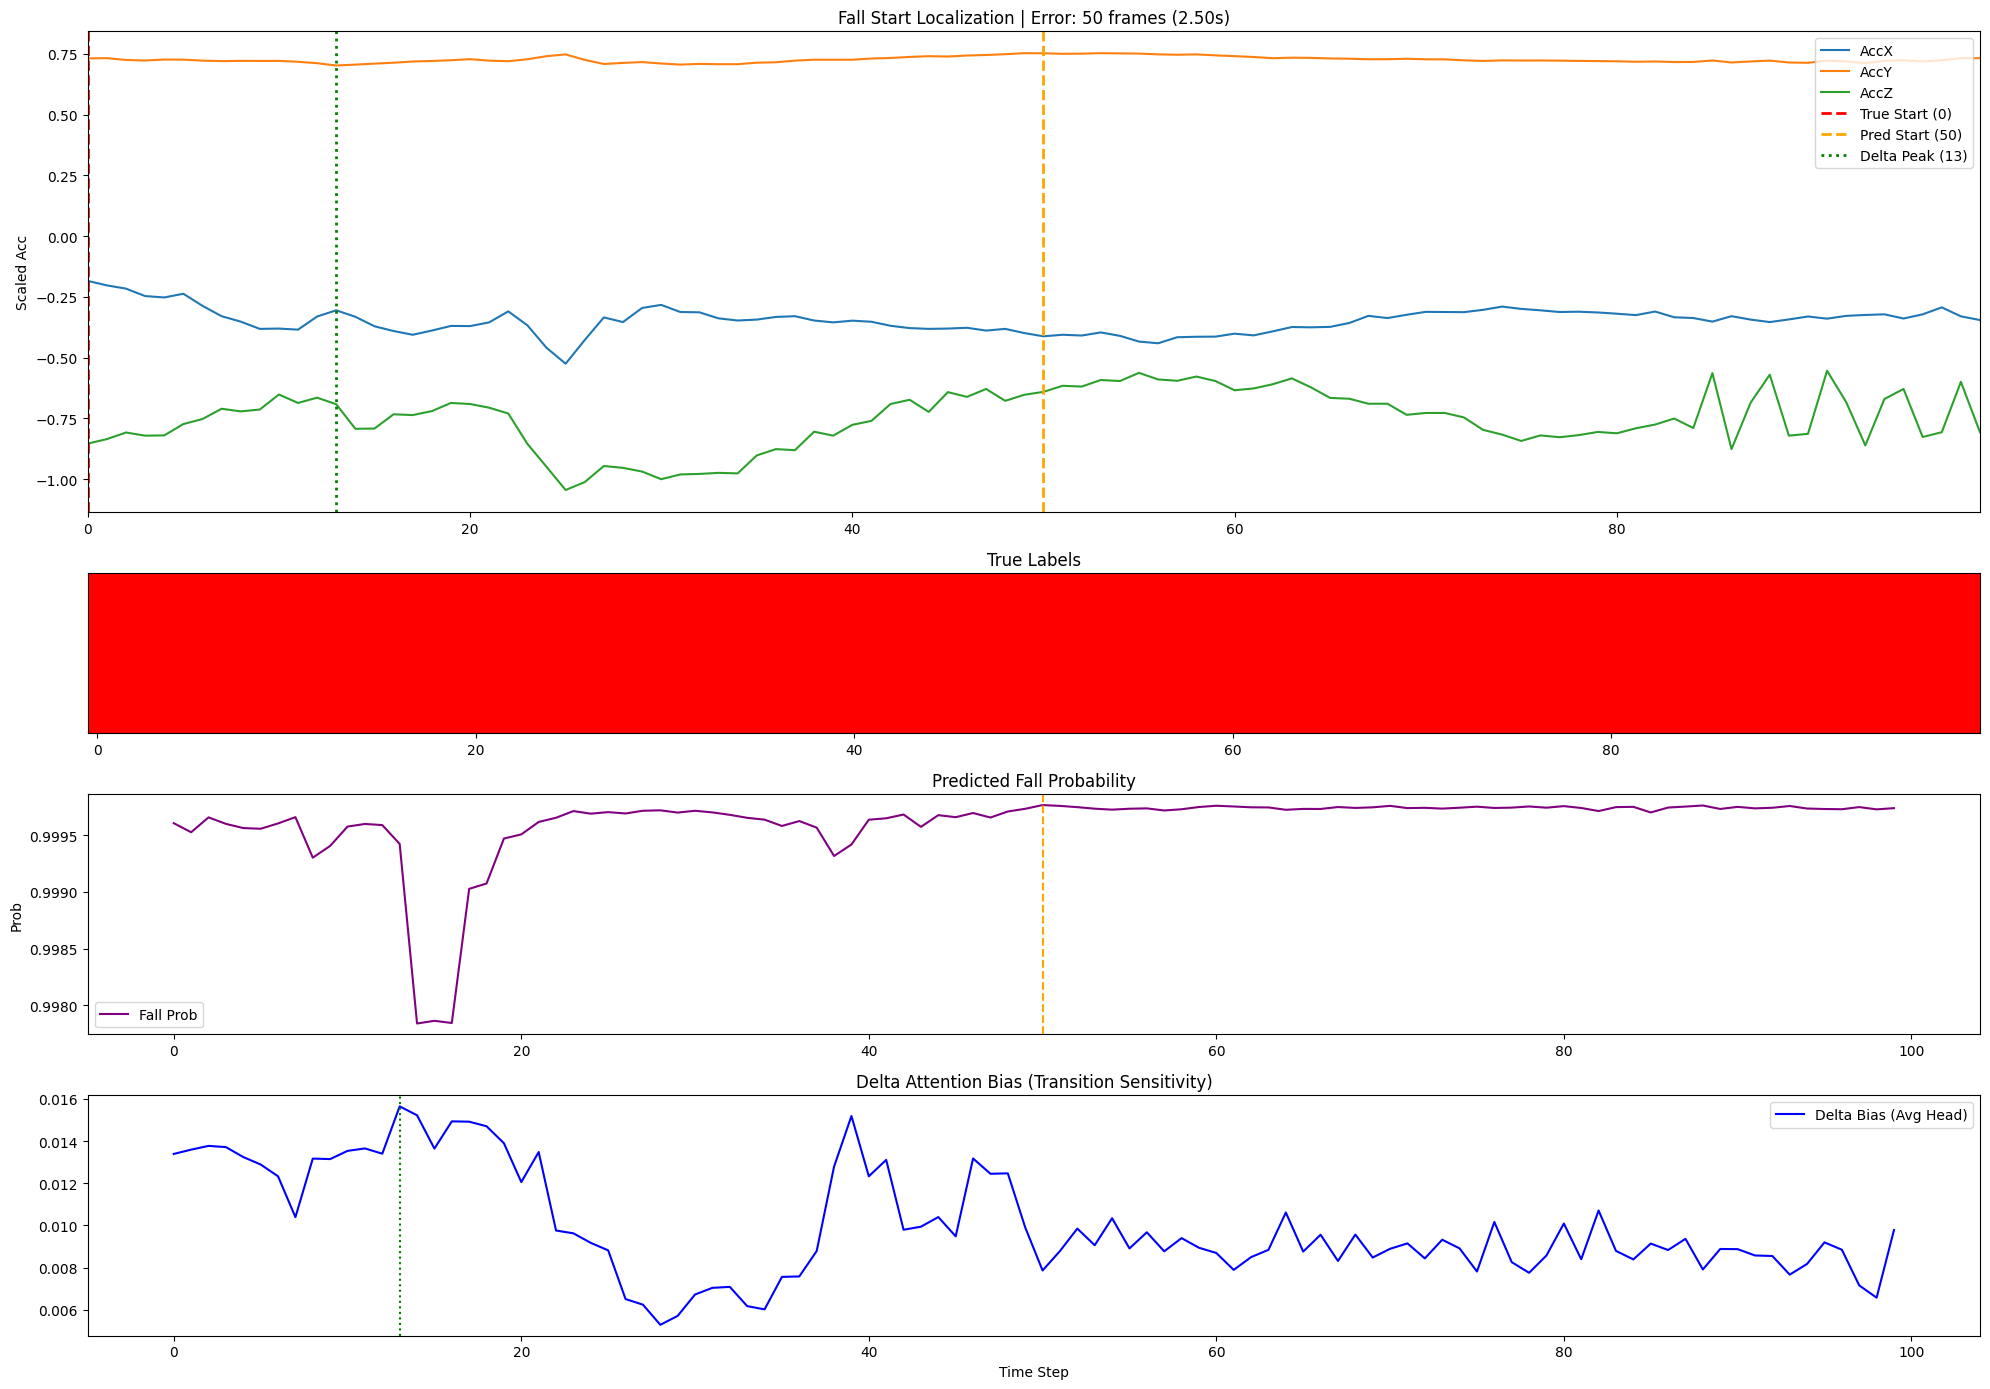

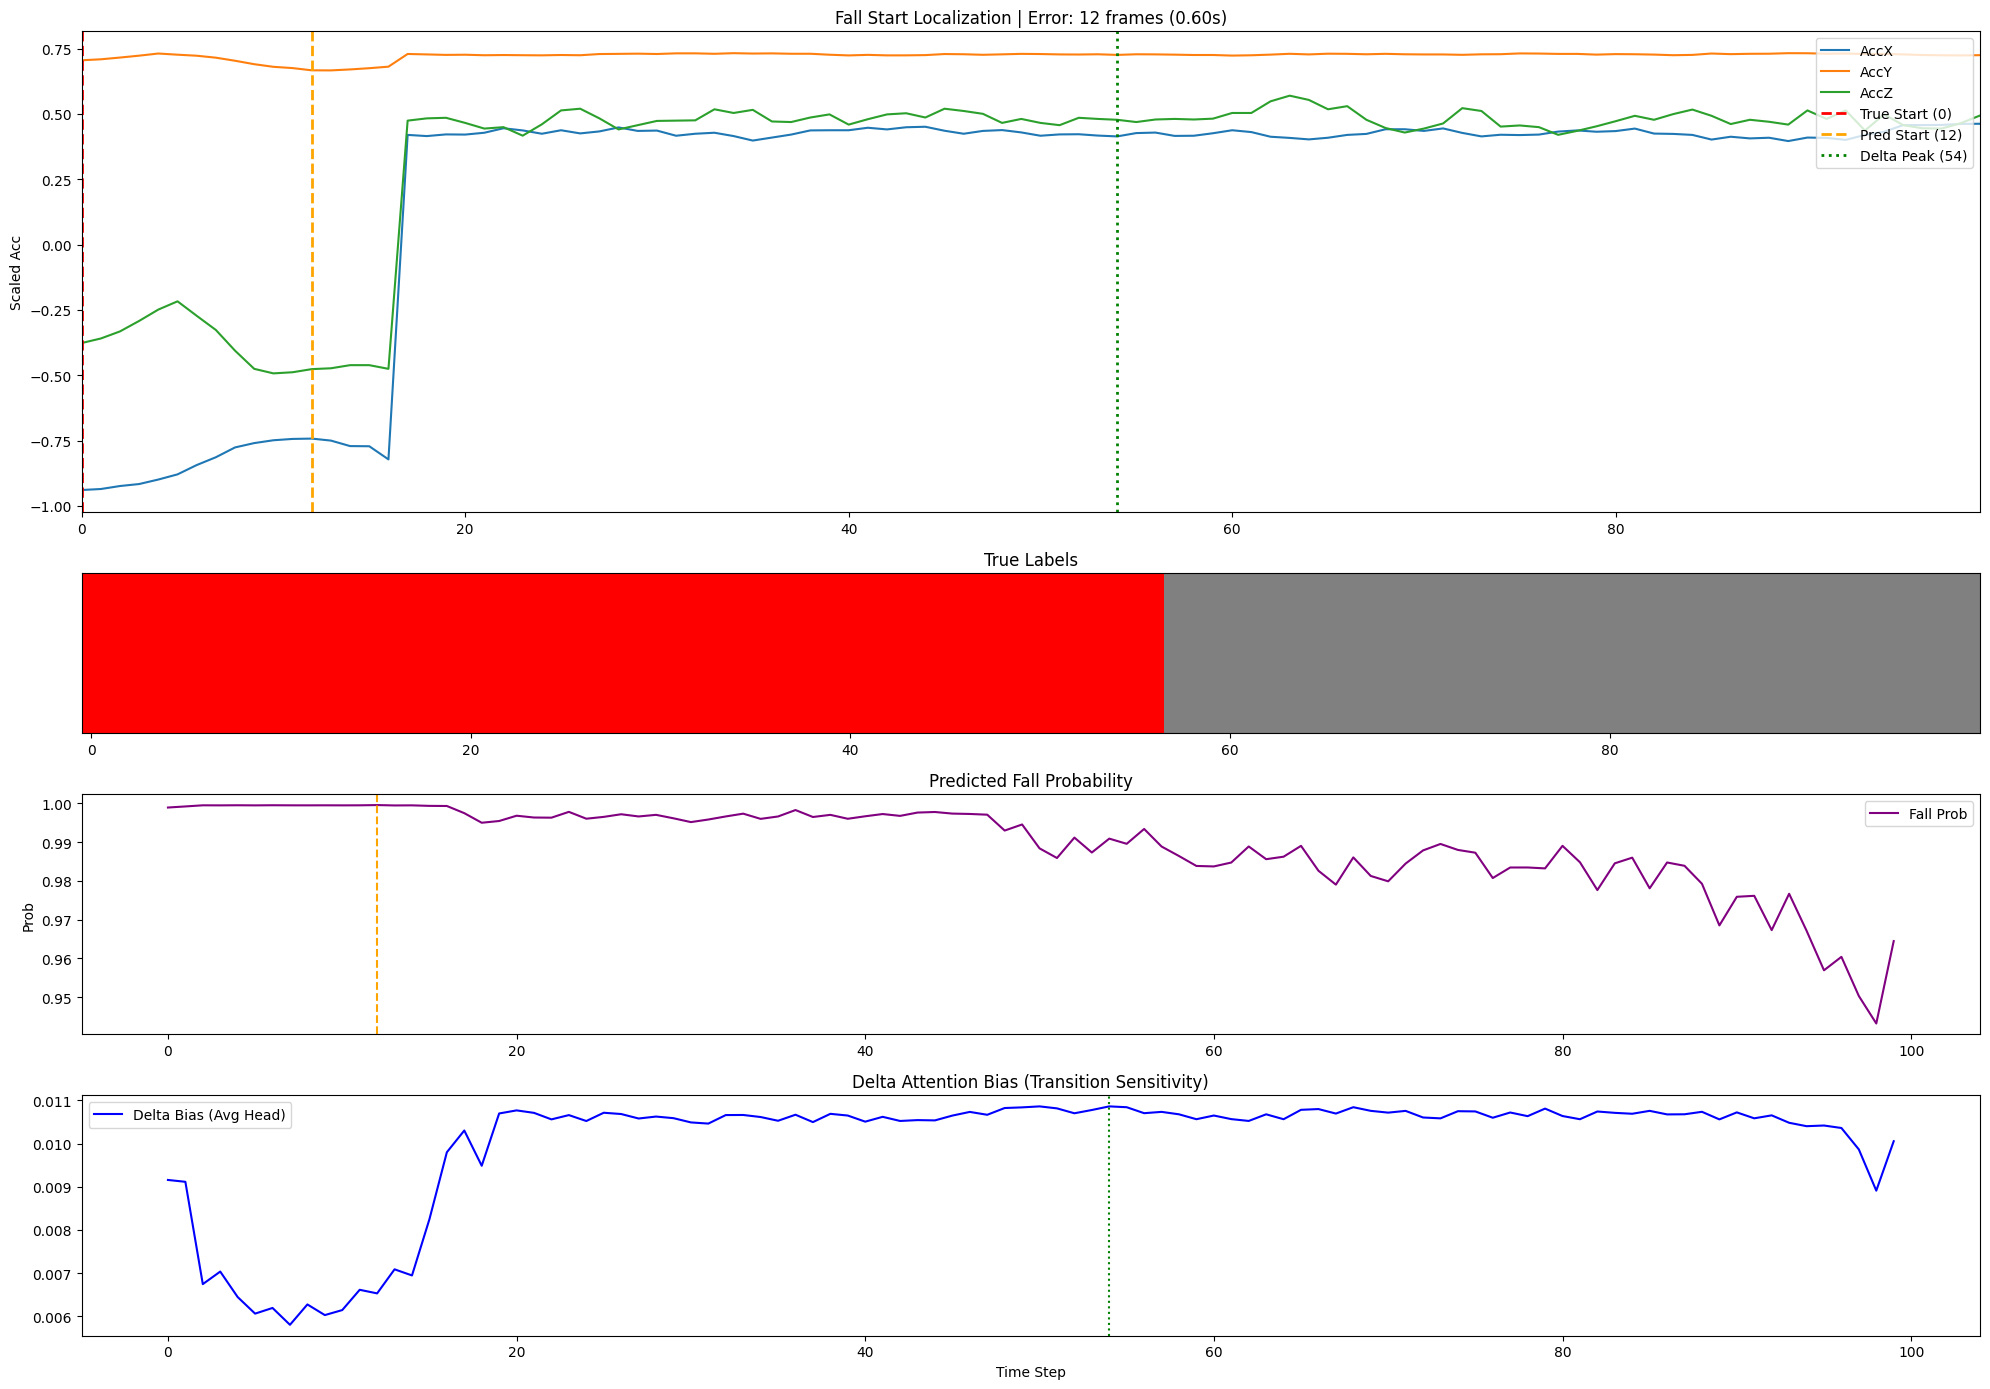

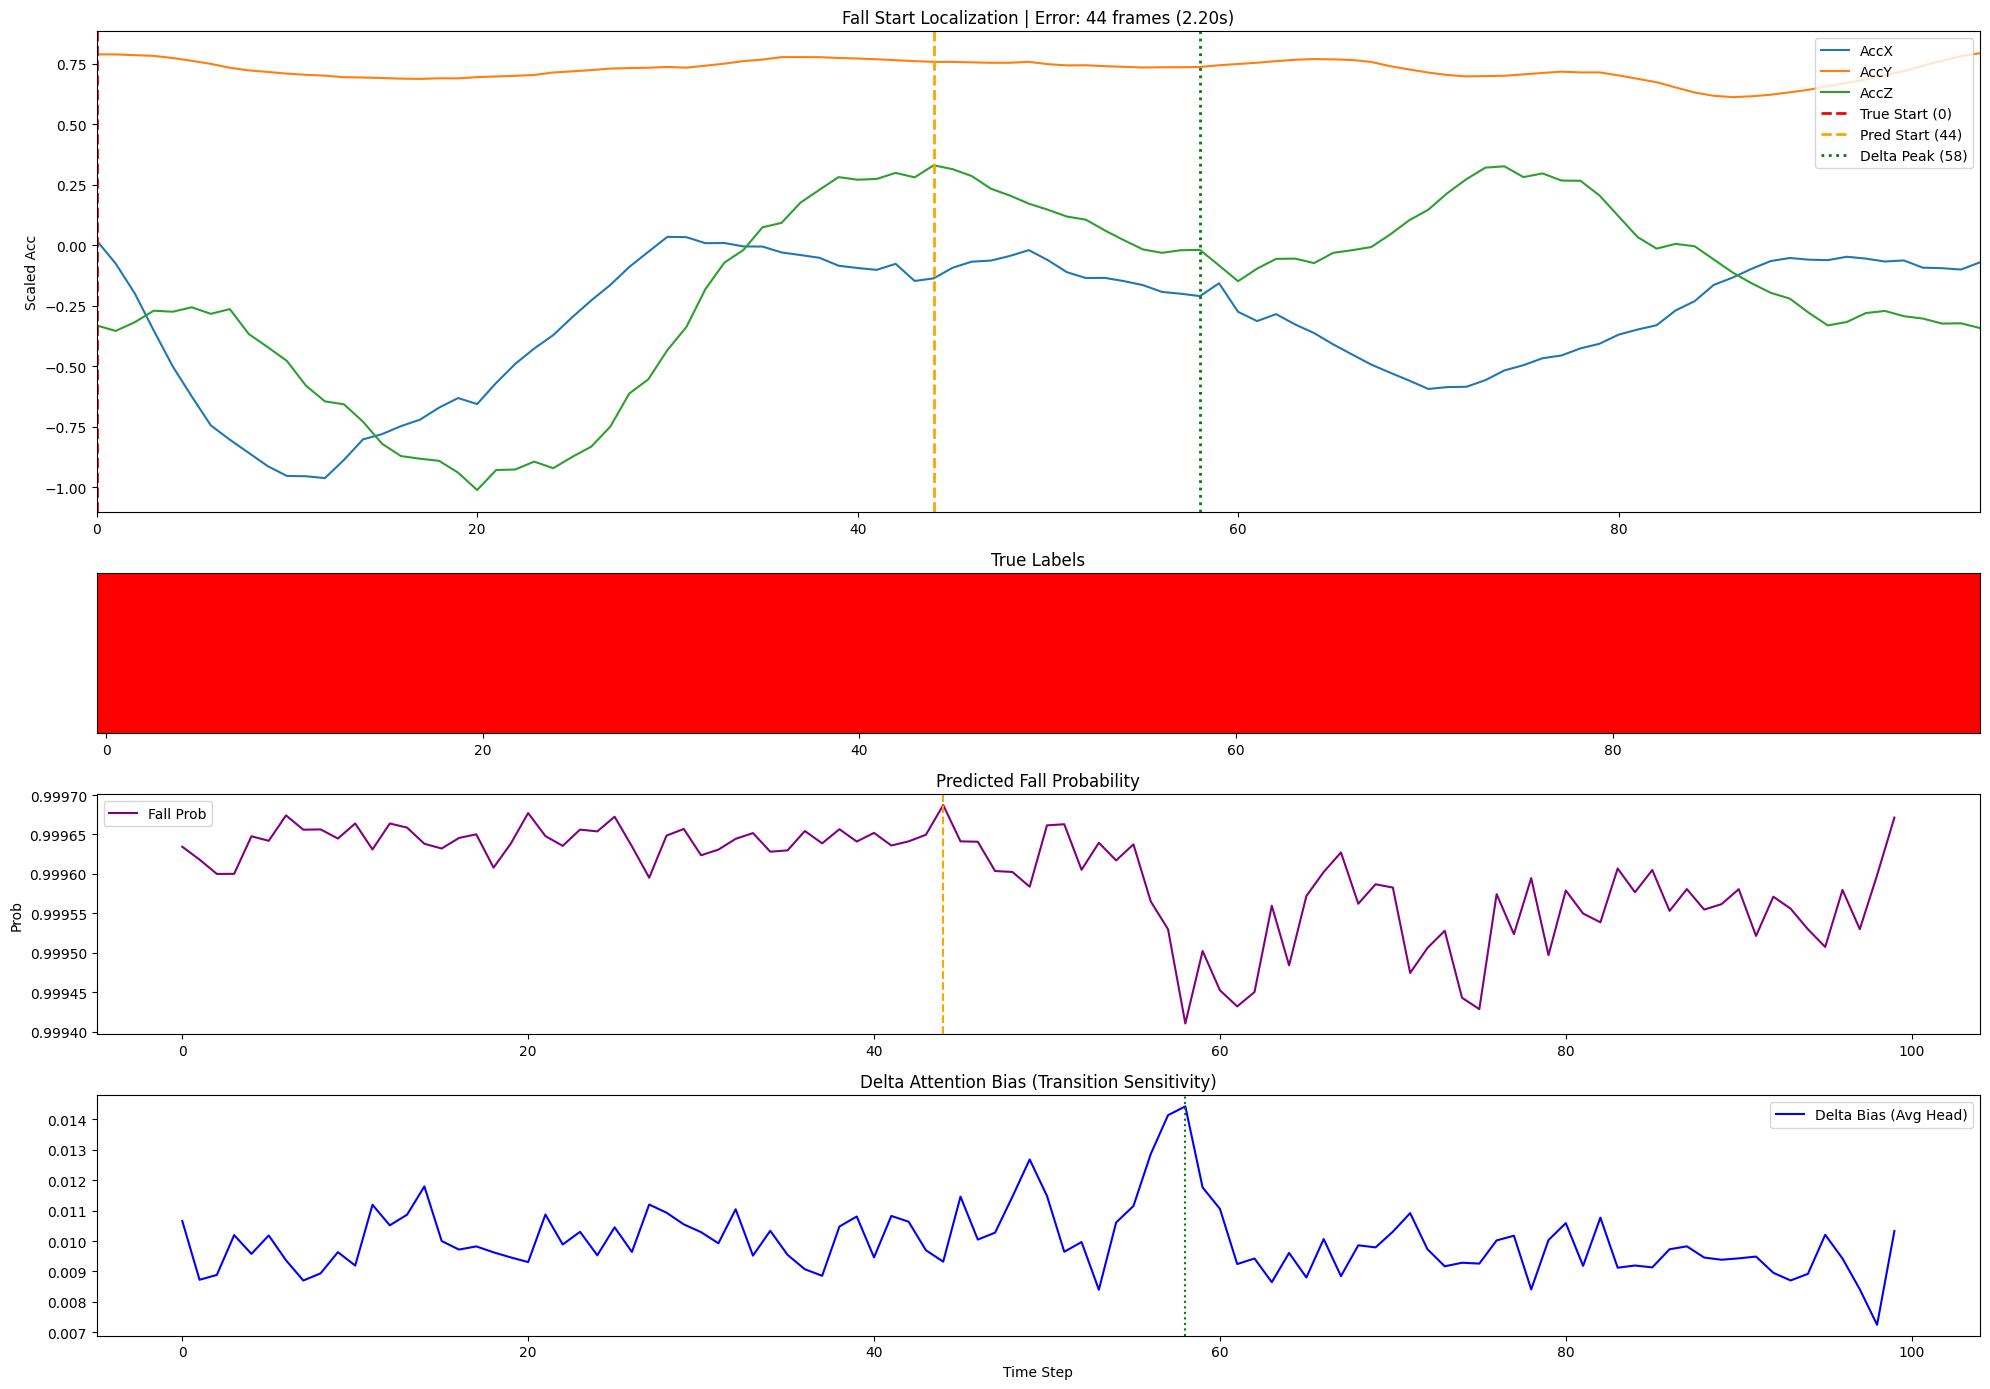

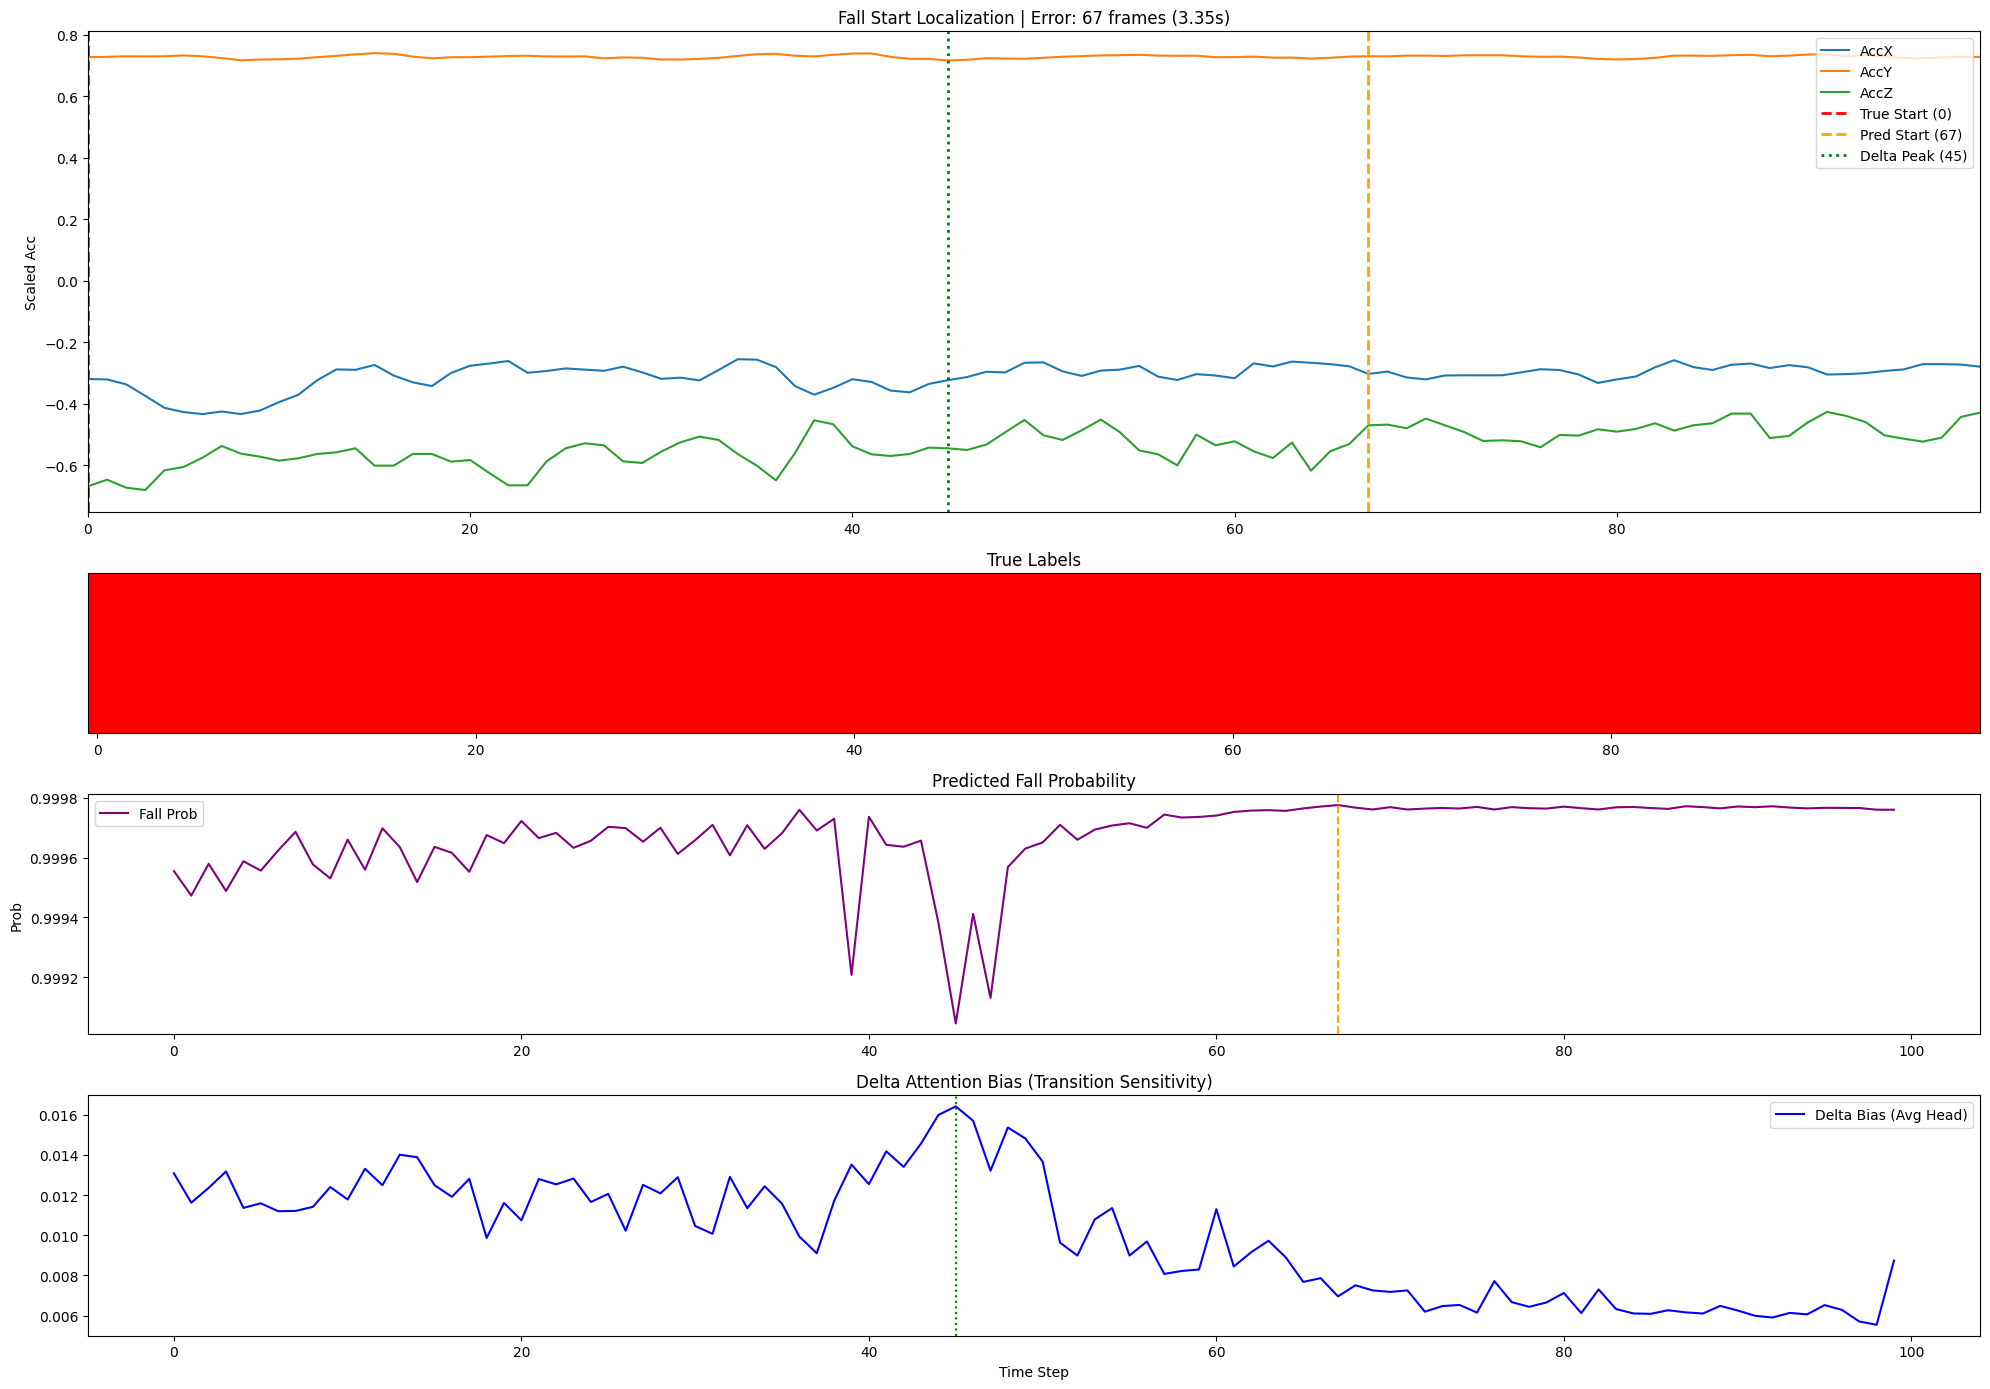

Params: 0.28M | FLOPs: 27.53M


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from thop import profile
import re
import time

class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class UMAFallLoader:
    def __init__(self, data_path, segment_len=100, stride=20, sr=20, pre_sec=2.0, post_sec=2.0):
        self.data_path = data_path
        self.segment_len = segment_len
        self.stride = stride
        self.sr = sr
        self.pre_len = int(sr * pre_sec)
        self.post_len = int(sr * post_sec)

    def parse_filename(self, filename):
        pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
        match = re.match(pattern, filename)
        if match:
            return int(match.group(1)), match.group(2), match.group(3), int(match.group(4)), match.group(5)
        return None

    def read_all_sensors_file(self, filepath):
        sensor_data = {'RIGHTPOCKET': {'id': None, 'data': []}, 'CHEST': {'id': None, 'data': []},
                       'WRIST': {'id': None, 'data': []}, 'WAIST': {'id': None, 'data': []}, 'ANKLE': {'id': None, 'data': []}}
        with open(filepath, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            if data_start and ';' in line:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    if len(values) < 7: continue
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except: continue
        for position in sensor_data:
            if sensor_data[position]['data']:
                sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
            else:
                sensor_data[position]['data'] = None
        return sensor_data

    def process_sensor_data(self, sensor_data):
        processed_data = {}
        valid_lengths = []
        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2
                acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
                gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
                mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
                if len(acc_data) > 0: valid_lengths.append(len(acc_data))
                if len(gyro_data) > 0: valid_lengths.append(len(gyro_data))
                if len(mag_data) > 0: valid_lengths.append(len(mag_data))
        if not valid_lengths: return None
        min_length = min(valid_lengths)
        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2
                if np.any(acc_mask):
                    acc_data = data['data'][acc_mask][:min_length, :3]
                    acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                    processed_data.update(dict(zip(acc_cols, acc_data.T)))
                if np.any(gyro_mask):
                    gyro_data = data['data'][gyro_mask][:min_length, :3]
                    gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                    processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
                if np.any(mag_mask):
                    mag_data = data['data'][mag_mask][:min_length, :3]
                    mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                    processed_data.update(dict(zip(mag_cols, mag_data.T)))
        if not processed_data: return None
        return pd.DataFrame(processed_data)

    def generate_pre_post_labels(self, raw_labels):
        labels = raw_labels.copy()
        fall_indices = np.where(raw_labels == 1)[0]
        for idx in fall_indices:
            start = max(0, idx - self.pre_len)
            end = min(len(labels), idx + self.post_len + 1)
            labels[start:end] = 1
        return labels

    def sliding_window(self, data, labels):
        segments = []
        segment_labels = []
        for i in range(0, len(data) - self.segment_len + 1, self.stride):
            segment = data[i:i + self.segment_len]
            label_segment = labels[i:i + self.segment_len]
            segments.append(segment)
            segment_labels.append(label_segment)
        return np.array(segments), np.array(segment_labels)

    def prepare_dataset(self, split_ratios):
        all_files = glob.glob(os.path.join(self.data_path, "*.csv"))
        subject_data = {}
        for file in all_files:
            filename = os.path.basename(file)
            info = self.parse_filename(filename)
            if info:
                subject_id = info[0]
                sensor_data = self.read_all_sensors_file(file)
                df = self.process_sensor_data(sensor_data)
                if df is not None:
                    df['activity'] = info[2]
                    if subject_id not in subject_data:
                        subject_data[subject_id] = []
                    subject_data[subject_id].append(df)
        subjects = sorted(subject_data.keys())
        all_segments_raw = []
        all_segment_labels = []
        for subject in subjects:
            dfs = subject_data.get(subject, [])
            if not dfs: continue
            subject_df = pd.concat(dfs, ignore_index=True)
            subject_df['activity'] = subject_df['activity'].map(lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0)
            subject_df = subject_df.dropna()
            sensor_columns = [col for col in subject_df.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
            if not sensor_columns: continue
            sensor_data_raw = subject_df[sensor_columns].values
            labels = subject_df['activity'].values
            labels_2class = self.generate_pre_post_labels(labels)
            segments, segment_labels = self.sliding_window(sensor_data_raw, labels_2class)
            if segments.size == 0: continue
            all_segments_raw.append(segments)
            all_segment_labels.append(segment_labels)
        if not all_segments_raw:
            return (np.array([]),) * 6
        X_all_raw = np.concatenate(all_segments_raw, axis=0)
        y_all = np.concatenate(all_segment_labels, axis=0)
        stratify_key = [1 if 1 in y_seg else 0 for y_seg in y_all]
        indices = np.arange(len(y_all))
        train_val_indices, test_indices = train_test_split(indices, test_size=split_ratios[2], random_state=42, stratify=stratify_key)
        val_size_ratio = split_ratios[1] / (split_ratios[0] + split_ratios[1])
        train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size_ratio, random_state=42, stratify=np.array(stratify_key)[train_val_indices])
        X_train_raw = X_all_raw[train_indices]
        y_train = y_all[train_indices]
        X_val_raw = X_all_raw[val_indices]
        y_val = y_all[val_indices]
        X_test_raw = X_all_raw[test_indices]
        y_test = y_all[test_indices]
        scaler = StandardScaler()
        n_features = X_train_raw.shape[2]
        X_train_2d = X_train_raw.reshape(-1, n_features)
        scaler.fit(X_train_2d)
        train_X = scaler.transform(X_train_2d).reshape(X_train_raw.shape)
        val_X = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape)
        test_X = scaler.transform(X_test_raw.reshape(-1, n_features)).reshape(X_test_raw.shape)
        return train_X, y_train, val_X, y_val, test_X, y_test

class FactorizedLinear(nn.Module):
    def __init__(self, in_features, out_features, r=4):
        super().__init__()
        mid_features = in_features // r
        self.net = nn.Sequential(nn.Linear(in_features, mid_features), nn.GELU(), nn.Linear(mid_features, out_features))
    def forward(self, x):
        return self.net(x)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv1d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch)
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, groups=1, bias=False, decay=0.9):
        super().__init__()
        self.padding = kernel_size - 1
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=0, groups=groups, bias=bias)
        k = self.conv.kernel_size[0]
        weights = torch.zeros_like(self.conv.weight.data)
        for i in range(k):
            weights[:, :, i] = (decay ** (k - 1 - i))
        weights = weights / weights.sum()
        self.conv.weight.data = weights.clone()
        self.conv.weight.requires_grad = False
    def forward(self, x):
        x_padded = F.pad(x, (self.padding, 0))
        return self.conv(x_padded)

class ProtoTPA(nn.Module):
    def __init__(self, dim, heads=4, num_classes=2, proto_tau=0.1, tau=1.0, bias_scale=1.0, r=4):
        super().__init__()
        assert dim % heads == 0
        self.dim = dim
        self.heads = heads
        self.dim_head = dim // heads
        self.num_classes = num_classes
        self.scale = self.dim_head ** -0.5
        self.tau = tau
        self.proto_tau = proto_tau
        self.bias_scale = bias_scale
        self.trend_extractor = CausalConv1d(in_channels=dim, out_channels=dim, kernel_size=20, groups=dim, decay=0.8)
        self.prototypes = nn.Parameter(torch.randn(num_classes, dim))
        self.q_proj = FactorizedLinear(dim, dim, r=r)
        self.k_proj = FactorizedLinear(dim, dim, r=r)
        self.v_proj = FactorizedLinear(dim, dim, r=r)
        self.out_proj = FactorizedLinear(dim, dim, r=r)
        self.delta_norm = nn.LayerNorm(dim)
        self.state_norm = nn.LayerNorm(dim)
        self.res_norm = nn.LayerNorm(dim)
        self.delta_net = nn.Sequential(FactorizedLinear(dim, dim * 2, r=r), nn.GELU(), nn.Linear(dim * 2, heads * 2))
        self.state_net = nn.Sequential(nn.Linear(num_classes, heads * 4), nn.GELU(), nn.Linear(heads * 4, heads))
        self.state_bias_weight = nn.Parameter(torch.tensor(0.1))
    def forward(self, x):
        B, T, D = x.shape
        H, Dh = self.heads, self.dim_head
        K = self.num_classes
        x_shifted = torch.roll(x, shifts=1, dims=1)
        x_shifted[:, 0, :] = 0.0
        x_shifted_permuted = x_shifted.permute(0, 2, 1)
        trend_permuted = self.trend_extractor(x_shifted_permuted)
        trend = trend_permuted.permute(0, 2, 1)
        delta = self.delta_norm(x - trend)
        gate_scores_all = self.delta_net(delta)
        logit_bias_scores, value_gate_logits = torch.chunk(gate_scores_all, 2, dim=-1)
        logit_bias_weights = F.softmax(logit_bias_scores.transpose(1, 2) / self.tau, dim=-1)
        logit_bias_from_delta = self.bias_scale * logit_bias_weights.unsqueeze(2)
        value_gate = torch.sigmoid(value_gate_logits).permute(0, 2, 1).unsqueeze(-1)
        x_norm = self.state_norm(x)
        p_norm = F.normalize(self.prototypes, dim=-1)
        state_affinity = torch.einsum('btd,kd->btk', x_norm, p_norm)
        state_bias_scores = self.state_net(state_affinity)
        state_bias_weights = F.softmax(state_bias_scores.transpose(1, 2) / self.proto_tau, dim=-1)
        logit_bias_from_state = state_bias_weights.unsqueeze(2)
        q = self.q_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        k = self.k_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        v_gated = v * value_gate
        logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        logits = logits + logit_bias_from_delta + (self.state_bias_weight * logit_bias_from_state)
        attn = F.softmax(logits, dim=-1)
        out = torch.matmul(attn, v_gated)
        out = out.permute(0, 2, 1, 3).reshape(B, T, D)
        out = self.out_proj(out)
        out = self.res_norm(x + out)
        return out, logit_bias_weights, state_bias_weights

class TPASegModel(nn.Module):
    def __init__(self, in_ch, dim, num_classes, heads, tau, bias_scale, proto_tau, r=4, segment_len=100):
        super().__init__()
        self.dim = dim
        self.input_proj = nn.Linear(in_ch, dim)
        self.pos_embed = nn.Parameter(torch.randn(1, segment_len, dim))
        self.cnn_block = nn.Sequential(DepthwiseSeparableConv(dim, dim, kernel_size=5, padding='same'), nn.GELU(), nn.BatchNorm1d(dim), nn.Dropout(0.3))
        self.tpa = ProtoTPA(dim=dim, heads=heads, num_classes=num_classes, proto_tau=proto_tau, tau=tau, bias_scale=bias_scale, r=r)
        self.out_proj = nn.Sequential(nn.Dropout(0.5), nn.Linear(dim, num_classes))
    def forward(self, x):
        B, T, _ = x.shape
        x = self.input_proj(x)
        x_cnn = x.permute(0, 2, 1)
        x_cnn = self.cnn_block(x_cnn)
        x_cnn = x_cnn.permute(0, 2, 1)
        x_res = x + x_cnn
        x_with_pos = x_res + self.pos_embed[:, :T, :]
        x_tpa, delta_bias_map, state_bias_map = self.tpa(x_with_pos)
        out = self.out_proj(x_tpa)
        return out, delta_bias_map, state_bias_map

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        B, T = y.shape
        optimizer.zero_grad()
        outputs, _, _ = model(X)
        num_classes = outputs.shape[-1]
        outputs_flat = outputs.view(-1, num_classes)
        y_flat = y.view(-1)
        loss = criterion(outputs_flat, y_flat)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * B
        _, predicted = outputs_flat.max(1)
        total += y_flat.size(0)
        correct += predicted.eq(y_flat).sum().item()
    return total_loss / len(loader.dataset), 100. * correct / total

def evaluate_transition(model, loader, criterion, device, sr=20):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds_flat = []
    all_labels_flat = []
    all_pred_probs = []
    all_labels_seg = []
    all_delta_bias_maps = []
    all_state_bias_maps = []
    all_X_data = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            B, T = y.shape
            outputs, delta_bias_map, state_bias_map = model(X)
            outputs_prob = F.softmax(outputs, dim=-1)
            num_classes = outputs.shape[-1]
            outputs_flat = outputs.view(-1, num_classes)
            y_flat = y.view(-1)
            loss = criterion(outputs_flat, y_flat)
            total_loss += loss.item() * B
            _, predicted_flat = outputs_flat.max(1)
            total += y_flat.size(0)
            correct += predicted_flat.eq(y_flat).sum().item()
            all_preds_flat.extend(predicted_flat.cpu().numpy())
            all_labels_flat.extend(y_flat.cpu().numpy())
            all_pred_probs.append(outputs_prob.cpu().numpy())
            all_labels_seg.append(y.cpu().numpy())
            all_delta_bias_maps.append(delta_bias_map.cpu().numpy())
            all_state_bias_maps.append(state_bias_map.cpu().numpy())
            all_X_data.append(X.cpu().numpy())
    all_pred_probs = np.concatenate(all_pred_probs, axis=0)
    all_labels_seg = np.concatenate(all_labels_seg, axis=0)
    all_delta_bias_maps = np.concatenate(all_delta_bias_maps, axis=0)
    all_state_bias_maps = np.concatenate(all_state_bias_maps, axis=0)
    all_X_data = np.concatenate(all_X_data, axis=0)
    seg_true = (np.sum(all_labels_seg, axis=1) > 0).astype(int)
    seg_pred = (np.sum(all_pred_probs[..., 1] > 0.5, axis=1) > 0).astype(int)
    seg_acc = accuracy_score(seg_true, seg_pred)
    seg_f1 = f1_score(seg_true, seg_pred, zero_division=0)
    fall_samples = [i for i, seq in enumerate(all_labels_seg) if np.any(seq == 1)]
    mae_frames_list = []
    iou_list = []
    for idx in fall_samples:
        true_seq = all_labels_seg[idx]
        pred_prob = all_pred_probs[idx, :, 1]
        true_fall = np.where(true_seq == 1)[0]
        pred_fall = np.where(pred_prob > 0.5)[0]
        if len(true_fall) == 0 or len(pred_fall) == 0: continue
        true_start = true_fall[0]
        pred_start = pred_fall[0]
        mae_frames_list.append(abs(true_start - pred_start))
        tp = np.sum((true_seq == 1) & (pred_prob > 0.5))
        union = np.sum((true_seq == 1) | (pred_prob > 0.5))
        iou_list.append(tp / union if union > 0 else 0)
    transition_mae_frames = np.mean(mae_frames_list) if mae_frames_list else float('inf')
    transition_mae_sec = transition_mae_frames / sr
    miou = np.mean(iou_list) if iou_list else 0.0
    return {
        'loss': total_loss / len(loader.dataset),
        'acc_timestep': 100. * correct / total,
        'seg_acc': seg_acc,
        'seg_f1': seg_f1,
        'transition_mae_frames': transition_mae_frames,
        'transition_mae_sec': transition_mae_sec,
        'miou': miou,
        'preds_flat': all_preds_flat,
        'labels_flat': all_labels_flat,
        'pred_probs': all_pred_probs,
        'labels_seg': all_labels_seg,
        'delta_bias_maps': all_delta_bias_maps,
        'state_bias_maps': all_state_bias_maps,
        'X_data': all_X_data
    }

def plot_fall_start_localization(X_data, y_true, y_pred_prob, delta_bias_maps, state_bias_maps, sr=20, num_samples=5):
    labels_map = {0: 'ADL', 1: 'Fall'}
    colors = ['gray', 'red']
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(np.arange(-0.5, 2), cmap.N)
    fall_indices = [i for i, seq in enumerate(y_true) if np.any(seq == 1)]
    if len(fall_indices) == 0:
        print("No fall samples for plotting.")
        return
    selected = np.random.choice(fall_indices, min(num_samples, len(fall_indices)), replace=False)
    print(f"Plotting {len(selected)} fall samples with start localization...")
    for idx in selected:
        signal = X_data[idx]
        true_labels = y_true[idx]
        pred_prob = y_pred_prob[idx, :, 1]
        delta_map = delta_bias_maps[idx].mean(axis=0)
        true_start = np.where(true_labels == 1)[0][0]
        pred_start = np.argmax(pred_prob)
        peak_bias = np.argmax(delta_map)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 1, 1.5, 1.5]})
        ax1.plot(signal[:, 0:3], label=['AccX', 'AccY', 'AccZ'])
        ax1.axvline(true_start, color='red', linestyle='--', linewidth=2, label=f'True Start ({true_start})')
        ax1.axvline(pred_start, color='orange', linestyle='--', linewidth=2, label=f'Pred Start ({pred_start})')
        ax1.axvline(peak_bias, color='green', linestyle=':', linewidth=2, label=f'Delta Peak ({peak_bias})')
        ax1.set_ylabel('Scaled Acc')
        ax1.set_title(f'Fall Start Localization | Error: {abs(true_start-pred_start)} frames ({abs(true_start-pred_start)/sr:.2f}s)')
        ax1.legend(loc='upper right')
        ax1.set_xlim(0, len(signal)-1)
        ax2.imshow(true_labels.reshape(1, -1), cmap=cmap, norm=norm, aspect='auto')
        ax2.set_title('True Labels')
        ax2.set_yticks([])
        ax3.plot(pred_prob, color='purple', label='Fall Prob')
        ax3.axvline(pred_start, color='orange', linestyle='--')
        ax3.set_title('Predicted Fall Probability')
        ax3.set_ylabel('Prob')
        ax3.legend()
        ax4.plot(delta_map, color='blue', label='Delta Bias (Avg Head)')
        ax4.axvline(peak_bias, color='green', linestyle=':')
        ax4.set_title('Delta Attention Bias (Transition Sensitivity)')
        ax4.set_xlabel('Time Step')
        ax4.legend()
        plt.tight_layout()
        plt.show()

def main():
    CONFIG = {
        'segment_len': 100,
        'stride': 20,
        'batch_size': 128,
        'epochs': 200,
        'hidden_dim': 256,
        'umafall_path': "/content/drive/MyDrive/HAR_Dataset/UMAFALL",
        'tpa_heads': 8,
        'tpa_tau': 1.0,
        'tpa_bias_scale': 1.0,
        'proto_tau': 0.1,
        'optim_r': 4,
        'class_weights': [0.5, 5.0],
        'sr': 20,
        'pre_sec': 2.0,
        'post_sec': 2.0,
        'split_ratios': [0.7, 0.15, 0.15]
    }
    np.random.seed(42)
    torch.manual_seed(42)
    loader = UMAFallLoader(CONFIG['umafall_path'], segment_len=CONFIG['segment_len'], stride=CONFIG['stride'], sr=CONFIG['sr'], pre_sec=CONFIG['pre_sec'], post_sec=CONFIG['post_sec'])
    train_X, train_y, val_X, val_y, test_X, test_y = loader.prepare_dataset(split_ratios=CONFIG['split_ratios'])
    if len(train_X) == 0:
        print("No training data.")
        return
    train_ds = FallDataset(train_X, train_y)
    val_ds = FallDataset(val_X, val_y)
    test_ds = FallDataset(test_X, test_y)
    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)
    in_channels = train_X.shape[2]
    num_classes = 2
    model = TPASegModel(in_ch=in_channels, dim=CONFIG['hidden_dim'], num_classes=num_classes, heads=CONFIG['tpa_heads'],
                        tau=CONFIG['tpa_tau'], bias_scale=CONFIG['tpa_bias_scale'], proto_tau=CONFIG['proto_tau'],
                        r=CONFIG['optim_r'], segment_len=CONFIG['segment_len'])
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    weights = torch.FloatTensor(CONFIG['class_weights'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    weights = weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    best_epoch = 0
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_results = evaluate_transition(model, val_loader, criterion, device, sr=CONFIG['sr'])
        scheduler.step(val_results['loss'])
        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_results['loss']:.4f} SegF1: {val_results['seg_f1']:.3f}")
        if val_results['loss'] < best_val_loss:
            best_val_loss = val_results['loss']
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
    model.load_state_dict(torch.load('best_model.pth'))
    test_results = evaluate_transition(model, test_loader, criterion, device, sr=CONFIG['sr'])
    print("\nFINAL TEST RESULTS")
    print(f"Timestep Acc: {test_results['acc_timestep']:.2f}%")
    print(f"Segment-level Acc: {test_results['seg_acc']:.3f} | F1: {test_results['seg_f1']:.3f}")
    print(f"Transition MAE: {test_results['transition_mae_frames']:.1f} frames ({test_results['transition_mae_sec']:.2f}s)")
    print(f"Fall Segment mIOU: {test_results['miou']:.3f}")
    plot_fall_start_localization(
        test_results['X_data'],
        test_results['labels_seg'],
        test_results['pred_probs'],
        test_results['delta_bias_maps'],
        test_results['state_bias_maps'],
        sr=CONFIG['sr'],
        num_samples=10
    )
    dummy_input = torch.randn(1, CONFIG['segment_len'], in_channels).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"Params: {params/1e6:.2f}M | FLOPs: {flops/1e6:.2f}M")

if __name__ == '__main__':
    main()